<a href="https://colab.research.google.com/github/ch-hee/Enefit-ML-project/blob/main/Enefit_PEBOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install polars==0.19.19

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.5/28.5 MB 28.3 MB/s eta 0:00:00
  Attempting uninstall: polars
    Found existing installation: polars 0.17.3
    Uninstalling polars-0.17.3:
      Successfully uninstalled polars-0.17.3


In [ ]:
import os

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

evaluation_metric = mean_absolute_error

In [ ]:
def feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_historical, df_location, df_target):
    df_data = (
        df_data
        .with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )
    )

    df_client = (
        df_client
        .with_columns(
            (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
        )
    )

    df_gas = (
        df_gas
        .rename({"forecast_date": "date"})
        .with_columns(
            (pl.col("date") + pl.duration(days=1)).cast(pl.Date),
            ((pl.col("lowest_price_per_mwh") + pl.col("highest_price_per_mwh")) / 2).alias("mean_price_per_mwh"),
        )
    )

    df_electricity = (
        df_electricity
        .rename({"forecast_date": "datetime"})
        .with_columns(
            pl.col("datetime") + pl.duration(days=1)
        )
    )

    df_location = (
        df_location
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32)
        )
    )

    df_forecast = (
        df_forecast
        .rename({"forecast_datetime": "datetime"})
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
            pl.col('datetime').dt.replace_time_zone(None).cast(pl.Datetime("us")),
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude", "hours_ahead")
    )
    for col in df_forecast.columns:
        df_forecast = df_forecast.filter(df_forecast[col].is_not_null())

    df_historical = (
        df_historical
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
            pl.col("datetime") + pl.duration(hours=37)
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
    )
    for col in df_historical.columns:
        df_historical = df_historical.filter(df_historical[col].is_not_null())

    df_forecast_date = (
        df_forecast
        .group_by("datetime").mean()
        .drop("county")
    )

    df_forecast_local = (
        df_forecast
        .filter(pl.col("county").is_not_null())
        .group_by("county", "datetime").mean()
    )
    county12_forecast = df_forecast_local.groupby("datetime").agg(pl.col('*').mean()).with_columns(pl.col('county').replace({7.2 : 12}).cast(pl.datatypes.Int64))
    county12_forecast = county12_forecast.select(df_forecast_local.columns)
    df_forecast_local = pl.concat([df_forecast_local, county12_forecast])

    df_historical_date = (
        df_historical
        .group_by("datetime").mean()
        .drop("county")
    )

    df_historical_local = (
        df_historical
        .filter(pl.col("county").is_not_null())
        .group_by("county", "datetime").mean()
    )
    county12_historical = df_historical_local.groupby("datetime").agg(pl.col('*').mean()).with_columns(pl.col('county').replace({7.2 : 12}).cast(pl.datatypes.Int64))
    county12_historical = county12_historical.select(df_historical_local.columns)
    df_historical_local = pl.concat([df_historical_local, county12_historical])

    df_data = (
        df_data
        .join(df_gas, on="date", how="left")

        .join(df_client, on=["county", "is_business", "product_type", "date"], how="left")
        .join(df_electricity, on="datetime", how="left")

        .join(df_forecast_date, on="datetime", how="left", suffix="_fd")
        .join(df_forecast_local, on=["county", "datetime"], how="left", suffix="_fl")
        .join(df_historical_date, on="datetime", how="left", suffix="_hd")
        .join(df_historical_local, on=["county", "datetime"], how="left", suffix="_hl")

        .join(df_forecast_date.with_columns(pl.col("datetime") + pl.duration(days=7)), on="datetime", how="left", suffix="_fd7")
        .join(df_forecast_local.with_columns(pl.col("datetime") + pl.duration(days=7)), on=["county", "datetime"], how="left", suffix="_fl7")
        .join(df_historical_date.with_columns(pl.col("datetime") + pl.duration(days=7)), on="datetime", how="left", suffix="_hd7")
        .join(df_historical_local.with_columns(pl.col("datetime") + pl.duration(days=7)), on=["county", "datetime"], how="left", suffix="_hl7")

        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=2)).rename({"target": "target_2_days_ago"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=3)).rename({"target": "target_3_days_ago"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=4)).rename({"target": "target_4_days_ago"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=5)).rename({"target": "target_5_days_ago"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=6)).rename({"target": "target_6_days_ago"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
        .join(df_target.with_columns(pl.col("datetime") + pl.duration(days=7)).rename({"target": "target_7_days_ago"}), on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")

        .with_columns(
            pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
            pl.col("datetime").dt.hour().alias("hour"),
            pl.col("datetime").dt.day().alias("day"),
            pl.col("datetime").dt.weekday().alias("weekday"),
            pl.col("datetime").dt.month().alias("month"),
            pl.col("datetime").dt.year().alias("year"),
        )

        .with_columns(
            pl.concat_str("county", "is_business", "product_type", "is_consumption", separator="_").alias("category_1"),
        )

        .with_columns(
            pl.col("weekday").apply(is_weekend).alias("isweekday"),
            (np.pi * pl.col("dayofyear") / 182.5).sin().alias("sin(dayofyear)"),
            (np.pi * pl.col("dayofyear") / 182.5).cos().alias("cos(dayofyear)"),
            (np.pi * pl.col("weekday") / 3.5).sin().alias("sin(weekday)"),
            (np.pi * pl.col("weekday") / 3.5).cos().alias("cos(weekday)"),
            (np.pi * pl.col("month") / 6).sin().alias("sin(month)"),
            (np.pi * pl.col("month") / 6).cos().alias("cos(month)"),
            (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
            (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
        )

        .with_columns(
            pl.col(pl.Float64).cast(pl.Float32),
        )

        # .drop("date", "datetime", "dayofyear")
    )

    return df_data

In [ ]:
def is_weekend(day_of_week):
    return 1 if day_of_week <= 5 else 0

In [ ]:
def to_pandas(X, y=None):
    cat_cols = ["county", "is_business", "product_type", "is_consumption", "category_1"]

    if y is not None:
        df = pd.concat([X.to_pandas(), y.to_pandas()], axis=1)
    else:
        df = X.to_pandas()

    df = df.set_index("row_id")
    df[cat_cols] = df[cat_cols].astype("category")

    for day in [2, 3, 4, 5, 6, 7]:
        df[f'target_{day}_days_ago_installed_capacity_ratio'] = df[f'target_{day}_days_ago'] / df['installed_capacity']
        df[f'target_{day}_days_ago_eic_count_ratio'] = df[f'target_{day}_days_ago'] / df['eic_count']

    df["target_mean"] = df[[f"target_{i}_days_ago" for i in range(2, 8)]].mean(1)
    df["target_std"] = df[[f"target_{i}_days_ago" for i in range(2, 8)]].std(1)
    df["target_var"] = df[[f"target_{i}_days_ago" for i in range(2, 8)]].var(1)
    df["target_ratio"] = df["target_6_days_ago"] / (df["target_7_days_ago"] + 1e-3)

    return df

In [ ]:
def fill_null(df):
    nan_columns = ["temperature_fl", "dewpoint_fl", "cloudcover_high_fl",
       "cloudcover_low_fl", "cloudcover_mid_fl", "cloudcover_total_fl",
       "10_metre_u_wind_component_fl", "10_metre_v_wind_component_fl",
       "direct_solar_radiation_fl", "surface_solar_radiation_downwards_fl",
       "snowfall_fl", "total_precipitation_fl", "temperature_hl",
       "dewpoint_hl", "rain_hl", "snowfall_hl", "surface_pressure_hl",
       "cloudcover_total_hl", "cloudcover_low_hl", "cloudcover_mid_hl",
       "cloudcover_high_hl", "windspeed_10m_hl", "winddirection_10m_hl",
       "shortwave_radiation_hl", "direct_solar_radiation_hl",
       "diffuse_radiation_hl"]

    df = df[df["target"].notnull() & (df["datetime"] >= pd.to_datetime("2021-09-10 00:00:00"))& ~df["target_7_days_ago"].isnull() & ~df["target_6_days_ago"].isnull() & ~df["target_5_days_ago"].isnull() & ~df["target_4_days_ago"].isnull() & ~df["target_3_days_ago"].isnull() & ~df["target_2_days_ago"].isnull()]

    temp_df = df.groupby("datetime")["euros_per_mwh"].mean().reset_index()
    temp_df["euros_per_mwh"] = temp_df["euros_per_mwh"].fillna((temp_df["euros_per_mwh"].shift(1) + temp_df["euros_per_mwh"].shift(-1)) / 2)
    df = df.drop(columns=["euros_per_mwh"])
    df = df.merge(temp_df, how="left", on="datetime")

    # df = df.set_index("datetime").combine_first(df.groupby(["datetime"])[nan_columns].mean()).reset_index()
    # df = df.set_index("datetime").fillna(df.groupby("datetime")[nan_columns].mean()).reset_index()
    df = df.drop(columns=["datetime", "date"])
    return df

In [ ]:
def new_features(df):

    for col in ['temperature', 'dewpoint', '10_metre_u_wind_component', '10_metre_v_wind_component', '10_metre_u_wind_component_fl',
                '10_metre_v_wind_component_fl', '10_metre_u_wind_component_fd7', '10_metre_v_wind_component_fd7', '10_metre_u_wind_component_fl7',
                '10_metre_v_wind_component_fl7']:
        for window in [1]:
            df[f"{col}_diff_{window}"] = df.groupby(["county", 'is_consumption', 'product_type', 'is_business'])[col].diff(window)

    return df

In [ ]:
data_cols        = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id']
client_cols      = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_cols         = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh']
electricity_cols = ['forecast_date', 'euros_per_mwh']
forecast_cols    = ['latitude', 'longitude', 'hours_ahead', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
historical_cols  = ['datetime', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure','cloudcover_total','cloudcover_low','cloudcover_mid','cloudcover_high','windspeed_10m','winddirection_10m','shortwave_radiation','direct_solar_radiation','diffuse_radiation','latitude','longitude']
location_cols    = ['longitude', 'latitude', 'county']
target_cols      = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime']

In [ ]:
root = '/content/drive/MyDrive/Data/enefit'

df_data        = pl.read_csv(os.path.join(root, "train.csv"), columns=data_cols, try_parse_dates=True)
df_client      = pl.read_csv(os.path.join(root, "client.csv"), columns=client_cols, try_parse_dates=True)
df_gas         = pl.read_csv(os.path.join(root, "gas_prices.csv"), columns=gas_cols, try_parse_dates=True)
df_electricity = pl.read_csv(os.path.join(root, "electricity_prices.csv"), columns=electricity_cols, try_parse_dates=True)
df_forecast    = pl.read_csv(os.path.join(root, "forecast_weather.csv"), columns=forecast_cols, try_parse_dates=True)
df_historical  = pl.read_csv(os.path.join(root, "historical_weather.csv"), columns=historical_cols, try_parse_dates=True)
df_location    = pl.read_csv(os.path.join(root, "county_location.csv"), columns=location_cols, try_parse_dates=True)
df_target      = df_data.select(target_cols)

schema_data        = df_data.schema
schema_client      = df_client.schema
schema_gas         = df_gas.schema
schema_electricity = df_electricity.schema
schema_forecast    = df_forecast.schema
schema_historical  = df_historical.schema
schema_target      = df_target.schema

In [ ]:
X, y = df_data.drop("target"), df_data.select("target")

X = feature_eng(X, df_client, df_gas, df_electricity, df_forecast, df_historical, df_location, df_target)

df = to_pandas(X, y)

df_train = fill_null(df.copy())

In [ ]:
df_train = new_features(df_train)

In [ ]:
missing_values = df_train[df_train.isnull().any(axis=1)].isnull().sum()

# 결측치가 있는 열만 선택하여 출력
columns_with_missing_values = missing_values[missing_values > 0]
columns_with_missing_values

Series([], dtype: float64)

In [ ]:
to_log = ["installed_capacity", "euros_per_mwh", "temperature", "temperature_fl", "dewpoint", "dewpoint_fl",
          "cloudcover_high", "cloudcover_high_fl", "cloudcover_low", "cloudcover_low_fl", "cloudcover_mid", "cloudcover_mid_fl",
          "cloudcover_total", "cloudcover_total_fl", "10_metre_u_wind_component", "10_metre_u_wind_component_fl", "10_metre_v_wind_component",
          "10_metre_v_wind_component_fl", "snowfall", "snowfall_fl", "total_precipitation", "total_precipitation_fl",
          "surface_solar_radiation_downwards", "surface_solar_radiation_downwards_fl", "direct_solar_radiation", "direct_solar_radiation_fl",
          "rain", "snowfall_hd", "windspeed_10m", "target_2_days_ago", "target_3_days_ago", "target_4_days_ago", "target_5_days_ago",
          "target_6_days_ago", "target_7_days_ago", "target_mean", "target_std"]
for i in to_log:
    df_train[f"log_{i}"]= np.where((df_train[i])!= 0, np.log(df_train[i]),0)

In [ ]:
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1979340 entries, 0 to 1979339
Data columns (total 205 columns):
 #    Column                                      Dtype   
---   ------                                      -----   
 0    county                                      category
 1    is_business                                 category
 2    product_type                                category
 3    is_consumption                              category
 4    lowest_price_per_mwh                        float32 
 5    highest_price_per_mwh                       float32 
 6    mean_price_per_mwh                          float32 
 7    eic_count                                   float64 
 8    installed_capacity                          float32 
 9    temperature                                 float32 
 10   dewpoint                                    float32 
 11   cloudcover_high                             float32 
 12   cloudcover_low                              float32 
 

In [ ]:
six_month = 3000 * 180
train = df_train.iloc[:-six_month]
val = df_train.iloc[-six_month:]
print(len(train), len(val))

1439340 540000


In [ ]:
train_cc_mask = (train['is_consumption'] == 1) & (train['is_business'] == 1)
train_cp_mask = (train['is_consumption'] == 0) & (train['is_business'] == 1)
train_rc_mask = (train['is_consumption'] == 1) & (train['is_business'] == 0)
train_rp_mask = (train['is_consumption'] == 0) & (train['is_business'] == 0)

X_cc = train[train_cc_mask].drop(columns=["target"])
y_cc = train[train_cc_mask]['target']

X_cp = train[train_cp_mask].drop(columns=["target"])
y_cp = train[train_cp_mask]['target']

X_rc = train[train_rc_mask].drop(columns=["target"])
y_rc = train[train_rc_mask]['target']

X_rp = train[train_rp_mask].drop(columns=["target"])
y_rp = train[train_rp_mask]['target']

In [ ]:
val_cc_mask = (val['is_consumption'] == 1) & (val['is_business'] == 1)
val_cp_mask = (val['is_consumption'] == 0) & (val['is_business'] == 1)
val_rc_mask = (val['is_consumption'] == 1) & (val['is_business'] == 0)
val_rp_mask = (val['is_consumption'] == 0) & (val['is_business'] == 0)

X_val_cc = val[val_cc_mask].drop(columns=["target"])
y_val_cc = val[val_cc_mask]['target']

X_val_cp = val[val_cp_mask].drop(columns=["target"])
y_val_cp = val[val_cp_mask]['target']

X_val_rc = val[val_rc_mask].drop(columns=["target"])
y_val_rc = val[val_rc_mask]['target']

X_val_rp = val[val_rp_mask].drop(columns=["target"])
y_val_rp = val[val_rp_mask]['target']

In [ ]:
best_params_cc = {'max_depth': 7, 'num_leaves': 59128, 'n_estimators': 1250, 'learning_rate': 0.0058346603527830426, 'min_data_in_leaf': 280, 'bagging_fraction': 0.5096602280355942, 'min_child_samples': 91, 'colsample_bytree': 0.42750433432490353, 'colsample_bynode': 0.5689523997454031, 'lambda_l1': 2.1579090814072295, 'lambda_l2': 9.722769033495345, 'max_bin': 366, 'verbose': -1, 'random_state' : 42, 'objective': 'regression'}
best_params_cp = {'max_depth': 9, 'num_leaves': 30676, 'n_estimators': 1468, 'learning_rate': 0.04057166831246957, 'min_data_in_leaf': 319, 'bagging_fraction': 0.36018338400737704, 'min_child_samples': 124, 'colsample_bytree': 0.7058438224276592, 'colsample_bynode': 0.7262960257275529, 'lambda_l1': 6.288226378683079, 'lambda_l2': 7.712505873580317, 'max_bin': 773, 'verbose': -1, 'random_state' : 42, 'objective': 'regression'}
best_params_rc = {'max_depth': 6, 'num_leaves': 30884, 'n_estimators': 836, 'learning_rate': 0.07484337292818556, 'min_data_in_leaf': 959, 'bagging_fraction': 0.702248676553715, 'min_child_samples': 239, 'colsample_bytree': 0.7471462522776671, 'colsample_bynode': 0.5285640208963883, 'lambda_l1': 1.8297171932144922, 'lambda_l2': 5.996117091646761, 'max_bin': 810, 'verbose': -1, 'random_state' : 42, 'objective': 'regression'}
best_params_rp = {'max_depth': 5, 'num_leaves': 48153, 'n_estimators': 754, 'learning_rate': 0.02869006156248729, 'min_data_in_leaf': 261, 'bagging_fraction': 0.6396358133538425, 'min_child_samples': 196, 'colsample_bytree': 0.7156421604286893, 'colsample_bynode': 0.6978564861522483, 'lambda_l1': 3.369691228249201, 'lambda_l2': 7.584852413098411, 'max_bin': 719, 'verbose': -1, 'random_state' : 42, 'objective': 'regression'}

In [ ]:
commercial_consume_model = LGBMRegressor(**best_params_cc)
commercial_produce_model = LGBMRegressor(**best_params_cp)
residential_consume_model = LGBMRegressor(**best_params_rc)
residential_produce_model = LGBMRegressor(**best_params_rp)

In [ ]:
commercial_consume_model.fit(
    X=X_cc,
    y=y_cc
)

commercial_produce_model.fit(
    X=X_cp,
    y=y_cp
)

residential_consume_model.fit(
    X=X_rc,
    y=y_rc
)

residential_produce_model.fit(
    X=X_rp,
    y=y_rp
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.348662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47654
[LightGBM] [Info] Number of data points in the train set: 385123, number of used features: 202
[LightGBM] [Info] Start training from score 714.978765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.780343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47654
[LightGBM] [Info] Number of data points in the train set: 385123, number of used features: 202
[LightGBM] [Info] Start training from score 72.362327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.525334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47681
[LightGBM] [Info] Number of data points in the

LGBMRegressor(random_state=42)

In [ ]:
commercial_consume_model_mae = evaluation_metric(y_val_cc, commercial_consume_model.predict(X_val_cc))
commercial_produce_model_mae = evaluation_metric(y_val_cp, commercial_produce_model.predict(X_val_cp))
residential_consume_model_mae = evaluation_metric(y_val_rc, residential_consume_model.predict(X_val_rc))
residential_produce_model_mae = evaluation_metric(y_val_rp, residential_produce_model.predict(X_val_rp))

print("commercial_consume_model Validation MAE : %.4f" % commercial_consume_model_mae)
print("commercial_produce_model Validation MAE : %.4f" % commercial_produce_model_mae)
print("residential_consume_model Validation MAE : %.4f" % residential_consume_model_mae)
print("residential_produce_model Validation MAE : %.4f" % residential_produce_model_mae)
print("Total Validation MAE : %.4f" % ((commercial_consume_model_mae + commercial_produce_model_mae + residential_consume_model_mae + residential_produce_model_mae) / 4))

commercial_consume_model Validation MAE : 101.4809
commercial_produce_model Validation MAE : 38.4104
residential_consume_model Validation MAE : 31.6153
residential_produce_model Validation MAE : 43.9598
Total Validation MAE : 53.8666


In [ ]:
train_mae = evaluation_metric(train['target'], model.predict(train.drop(columns=['target'])))
val_mae = evaluation_metric(val['target'], model.predict(val.drop(columns=['target'])))

print(f'Train mae : {train_mae}')
print(f'Validation mae : {val_mae}')

Train mae : 38.63774080089657
Validation mae : 59.735884398646434


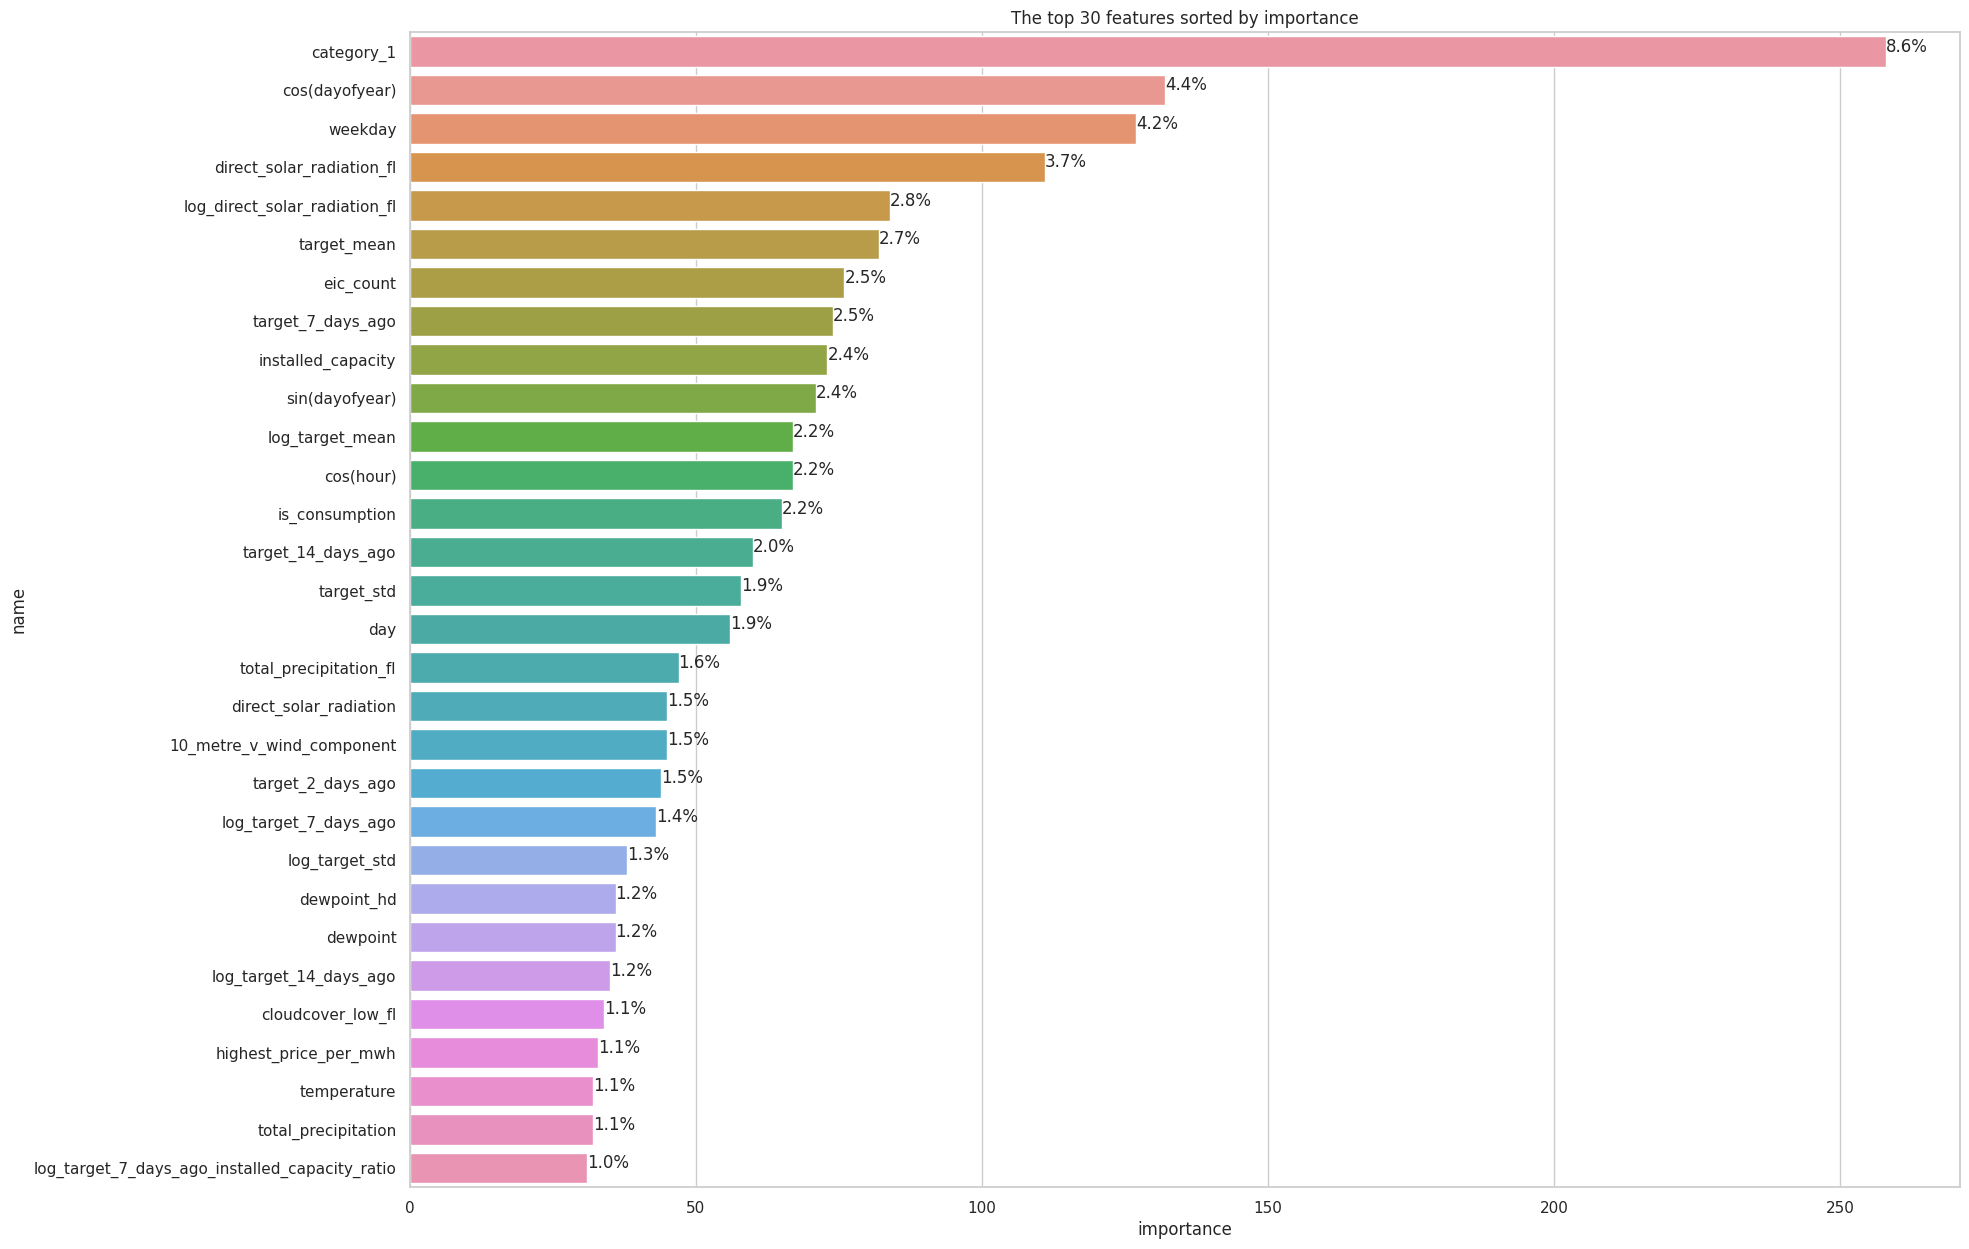

In [ ]:
TOP = 30
importance_data = pd.DataFrame({'name': model.feature_name_, 'importance': model.feature_importances_})
importance_data = importance_data.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(20, 15))
sns.barplot(data=importance_data[:TOP],
            x='importance',
            y='name'
            )
patches = ax.patches
count = 0
total_importance = importance_data['importance'].sum()  # 전체 중요도의 합을 계산
for patch in patches:
    height = patch.get_height()
    width = patch.get_width()
    perc = 100 * importance_data['importance'].iloc[count] / total_importance  # 비율 계산
    ax.text(width, patch.get_y() + height / 2, f'{perc:.1f}%')  # 비율 출력
    count += 1

plt.title(f'The top {TOP} features sorted by importance')
plt.show()